<a href="https://colab.research.google.com/github/RecoHut-Projects/recohut/blob/master/tutorials/modeling/deep_vae_filmtrust_tf2.7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Variational Models on FilmTrust, ML-1m, and MyAnimeList Dataset in Tensorflow

## Summary

| Category | Description |
| --- | --- |
| Problem | Deep learning provides accurate collaborative filtering models to improve recommender system results. Deep matrix factorization and their related collaborative neural networks are the state-of-art in the field; nevertheless, both models lack the necessary stochasticity to create the robust, continuous, and structured latent spaces that variational autoencoders exhibit. On the other hand, data augmentation through variational autoencoder does not provide accurate results in the collaborative filtering field due to the high sparsity of recommender systems. |
| Hypothesis | Rating values can be better predicted when a variational latent space has been learnt, because this space covers a wider, more robust, and more representative latent area. The augmented samples will be more accurate and effective if they are generated in an inner and dense latent space rather than in a very sparse input space. |
| Benefits | This method does not depend on the particular model used to generate the latent representation. In this way, this approach can be applied as a plugin to any current and future specific models. |
| Solution | This models apply the variational concept to inject stochasticity in the latent space of the deep architecture, introducing the variational technique in the neural collaborative filtering field. |
| Dataset | FilmTrust, MovieLens-1m, MyAnimeList |
| Preprocessing | Dataset is already processed. Three fields - userid, itemid, rating. |
| Metrics | MAE, MSE, Precision, Recall, NDCG |
| Models | Neural Collaborative Filtering (NCF), Deep Matrix Factorization (DeepMF), Variational NCF (VNCF), Variational DeepMF (VDeepMF) |
| Cluster | Tensorflow 2.7 |
| Tags | VariationalAutoencoder, DeepMF, NCF |

## Core Model Architecture

<p><center><figure><img src='https://github.com/RecoHut-Stanzas/S394070/blob/main/images/model.png?raw=true'><figcaption><i>Proposed VDeepMF architecture. The NCF architecture will have identical ‘Embedding’ and ‘Variational’ layers to the VDeepMF one; it will just replace the ‘Dot’ layer for a ‘Concatenate’ layer, followed by an MLP.</i></figcaption></figure></center></p>

## Process Flow

<img src='https://raw.githubusercontent.com/RecoHut-Stanzas/S394070/main/images/flow.svg'>

In [ ]:
!wget -q --show-progress https://github.com/RecoHut-Datasets/filmtrust/raw/v1/ft.csv
!wget -q --show-progress https://github.com/RecoHut-Datasets/movielens_1m/raw/v3/ml1m.csv
!wget -q --show-progress https://github.com/RecoHut-Datasets/myanimelist/raw/v1/anime.zip
!unzip anime.zip

ft.csv              100%[===================>]   8.16M  --.-KB/s    in 0.07s   
ml1m.csv            100%[===================>]  13.75M  --.-KB/s    in 0.09s   
anime.zip           100%[===================>]  18.66M  --.-KB/s    in 0.1s    
Archive:  anime.zip
  inflating: anime.csv               


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Embedding, Flatten, Input, Dropout, Dense, Concatenate, Dot, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

from sklearn.metrics import precision_score, recall_score, ndcg_score, mean_absolute_error, mean_squared_error, r2_score

In [ ]:
class Args:
    def __init__(self, dataset):
        self.dataset = dataset
        if dataset == 'ml1m':
            self.latent_dim = 5
            self.like_threshold = 4
            self.steps_per_epoch = None
            self.deepmf_epochs = 10
            self.ncf_epochs = 10
            self.vdeepmf_epochs = 6
            self.vncf_epochs = 9
        elif dataset == 'ft':
            self.latent_dim = 5
            self.like_threshold = 3
            self.steps_per_epoch = None
            self.deepmf_epochs = 15
            self.ncf_epochs = 8
            self.vdeepmf_epochs = 10
            self.vncf_epochs = 6
        elif dataset == 'anime':
            self.latent_dim = 7
            self.like_threshold = 8
            self.steps_per_epoch = None
            self.deepmf_epochs = 20
            self.ncf_epochs = 15
            self.vdeepmf_epochs = 9
            self.vncf_epochs = 9

In [ ]:
args = Args(dataset='ft')

In [ ]:
df = pd.read_csv(args.dataset+'.csv', delimiter = ',')

num_users = df.user.max() + 1
num_items = df.item.max() + 1

X = df[['user', 'item']].to_numpy()
y = df[['rating']].to_numpy()

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

X_train = [X_train[:,0], X_train[:,1]]
X_test = [X_test[:,0], X_test[:,1]]

DeepMF

In [ ]:
user_input = Input(shape=[1])
user_embedding = Embedding(num_users, args.latent_dim)(user_input)
user_vec = Flatten()(user_embedding)

item_input = Input(shape=[1])
item_embedding = Embedding(num_items, args.latent_dim)(item_input)
item_vec = Flatten()(item_embedding) 
        
dot = Dot(axes=1)([item_vec, user_vec])
    
DeepMF = Model([user_input, item_input], dot)

DeepMF.compile(optimizer='adam', metrics=['mae'], loss='mean_squared_error')
DeepMF.summary()

deepmf_report = DeepMF.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=args.deepmf_epochs, steps_per_epoch=args.steps_per_epoch, verbose=1)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 5)         10355       ['input_2[0][0]']                
                                                                                                  
 embedding (Embedding)          (None, 1, 5)         7540        ['input_1[0][0]']                
                                                                                              

NCF

In [ ]:
item_input = Input(shape=[1], name='item-input')
item_embedding = Embedding(num_items, args.latent_dim, name='item-embedding')(item_input)
item_vec = Flatten(name='item-flatten')(item_embedding)

user_input = Input(shape=[1], name='user-input')
user_embedding = Embedding(num_users, args.latent_dim, name='user-embedding')(user_input)
user_vec = Flatten(name='user-flatten')(user_embedding)

concat = Concatenate(axis=1, name='item-user-concat')([item_vec, user_vec])
fc_1 = Dense(70, name='fc-1', activation='relu')(concat)
fc_1_dropout = Dropout(0.5, name='fc-1-dropout')(fc_1)
fc_2 = Dense(30, name='fc-2', activation='relu')(fc_1_dropout)
fc_2_dropout = Dropout(0.4, name='fc-2-dropout')(fc_2)
fc_3 = Dense(1, name='fc-3', activation='relu')(fc_2_dropout)

NCF = Model([user_input, item_input], fc_3)

NCF.compile(optimizer='adam', metrics=['mae'], loss='mean_squared_error')
NCF.summary()
    
ncf_report = NCF.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=args.ncf_epochs, steps_per_epoch=args.steps_per_epoch, verbose=1)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 item-input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 user-input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 item-embedding (Embedding)     (None, 1, 5)         10355       ['item-input[0][0]']             
                                                                                                  
 user-embedding (Embedding)     (None, 1, 5)         7540        ['user-input[0][0]']             
                                                                                            

VDeepMF

In [ ]:
batch_size = 32

def sampling(qargs):
    z_mean, z_var = qargs
    epsilon = K.random_normal(shape=(batch_size, args.latent_dim), mean=0., stddev=1)
    return z_mean + K.exp(z_var) * epsilon

user_input = Input(shape=[1])
user_embedding = Embedding(num_users, args.latent_dim)(user_input)
user_embedding_mean = Dense(args.latent_dim)(user_embedding)
user_embedding_var = Dense(args.latent_dim)(user_embedding)
user_embedding_z = Lambda(sampling)([user_embedding_mean, user_embedding_var])
user_vec = Flatten()(user_embedding_z)

item_input = Input(shape=[1])
item_embedding = Embedding(num_items, args.latent_dim)(item_input)
item_embedding_mean = Dense(args.latent_dim)(item_embedding)
item_embedding_var = Dense(args.latent_dim)(item_embedding)
item_embedding_z = Lambda(sampling)([item_embedding_mean, item_embedding_var], args.latent_dim)
item_vec = Flatten()(item_embedding_z)

dot = Dot(axes=1)([item_vec, user_vec])

VDeepMF = Model([user_input, item_input], dot)

VDeepMF.compile(optimizer='adam', metrics=['mae'], loss='mean_squared_error')
VDeepMF.summary()

vdeepmf_report = VDeepMF.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=args.vdeepmf_epochs, batch_size=batch_size, steps_per_epoch=args.steps_per_epoch, verbose=1)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, 1, 5)         10355       ['input_4[0][0]']                
                                                                                                  
 embedding_2 (Embedding)        (None, 1, 5)         7540        ['input_3[0][0]']                
                                                                                            

VNCF

In [ ]:
batch_size = 32

def sampling(qargs):
    z_mean, z_var = qargs
    epsilon = K.random_normal(shape=(batch_size, args.latent_dim), mean=0., stddev=1)
    return z_mean + K.exp(z_var) * epsilon

user_input = Input(shape=[1])
user_embedding = Embedding(num_users, args.latent_dim)(user_input)
user_embedding_mean = Dense(args.latent_dim)(user_embedding)
user_embedding_var = Dense(args.latent_dim)(user_embedding)
user_embedding_z = Lambda(sampling)([user_embedding_mean, user_embedding_var])
user_vec = Flatten()(user_embedding_z)

item_input = Input(shape=[1])
item_embedding = Embedding(num_items + 1, args.latent_dim)(item_input)
item_embedding_mean = Dense(args.latent_dim)(item_embedding)
item_embedding_var = Dense(args.latent_dim)(item_embedding)
item_embedding_z = Lambda(sampling)([item_embedding_mean, item_embedding_var], args.latent_dim)
item_vec = Flatten()(item_embedding_z)

concat = Concatenate(axis=1)([item_vec, user_vec])

fc_1 = Dense(80, name='fc-1', activation='relu')(concat)
fc_1_dropout = Dropout(0.6, name='fc-1-dropout')(fc_1)
fc_2 = Dense(25, name='fc-2', activation='relu')(fc_1_dropout)
fc_2_dropout = Dropout(0.4, name='fc-2-dropout')(fc_2)
fc_3 = Dense(1, name='fc-3', activation='relu')(fc_2_dropout)

VNCF = Model([user_input, item_input], fc_3)

VNCF.compile(optimizer='adam', metrics=['mae'], loss='mean_squared_error')
VNCF.summary()

vncf_report = VNCF.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=args.vncf_epochs, batch_size=batch_size, steps_per_epoch=args.steps_per_epoch, verbose=1)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding_5 (Embedding)        (None, 1, 5)         10360       ['input_6[0][0]']                
                                                                                                  
 embedding_4 (Embedding)        (None, 1, 5)         7540        ['input_5[0][0]']                
                                                                                            

### Results

In [ ]:
methods = ['vdeepmf', 'deepmf', 'vncf', 'ncf']

preds = pd.DataFrame()
preds['user'] = X_test[0]
preds['item'] = X_test[1]
preds['y_test'] = y_test

preds['deepmf'] = DeepMF.predict(X_test)
preds['ncf'] = NCF.predict(X_test)

Due to the variational approachs of the proposed methods, the same model can generates different predictions for the same <user, item> input. To avoid this, we compute the predictions of the proposed models as the average of 10 repetitions of the same prediction.

In [ ]:
n_repeats = 10

In [ ]:
predictions = None
for i in range(n_repeats):
    if i == 0:
        predictions = VDeepMF.predict(X_test)
    else:
        predictions = np.append(predictions, VDeepMF.predict(X_test), axis=1)
        
preds['vdeepmf'] = np.mean(predictions, axis=1)
predictions = None

In [ ]:
for i in range(n_repeats):
    if i == 0:
        predictions = VNCF.predict(X_test)
    else:
        predictions = np.append(predictions, VNCF.predict(X_test), axis=1)

preds['vncf'] = np.mean(predictions, axis=1)

Quality of predictions

In [ ]:
print('MAE:')
for m in methods:
    print('-', m, ':', mean_absolute_error(preds['y_test'], preds[m]))

print('MSD:')
for m in methods:
    print('-', m, ':', mean_squared_error(preds['y_test'], preds[m]))

print('R2:')
for m in methods:
    print('-', m, ':', r2_score(preds['y_test'], preds[m]))

MAE:
- vdeepmf : 0.6682701121602727
- deepmf : 0.796373496434136
- vncf : 0.6794240521383816
- ncf : 0.628886068181297
MSD:
- vdeepmf : 0.7811135134568459
- deepmf : 1.206644394774836
- vncf : 0.7096441554816355
- ncf : 0.6704391027374016
R2:
- vdeepmf : 0.08685039587840626
- deepmf : -0.41061040735029475
- vncf : 0.17040062874157558
- ncf : 0.21623273608091598


Quality of the recommendations

In [ ]:
num_recommendations = [2,3,4,5,6,7,8,9,10]

def recommender_precision_recall(X, y_true, y_pred, N, threshold):
    precision = 0
    recall = 0
    count = 0
    
    rec_true = np.array([1 if rating >= threshold else 0 for rating in y_true])
    rec_pred = np.zeros(y_pred.size)
    
    for user_id in np.unique(X[:,0]):
        indices = np.where(X[:,0] == user_id)[0]
        
        rec_true = np.array([1 if y_true[i] >= threshold else 0 for i in indices])

        if (np.count_nonzero(rec_true) > 0): # ignore test users without relevant ratings
        
            user_pred = np.array([y_pred[i] for i in indices])
            rec_pred = np.zeros(indices.size)

            for pos in np.argsort(user_pred)[-N:]:
                if user_pred[pos] >= threshold:
                    rec_pred[pos] = 1
            
            precision += precision_score(rec_true, rec_pred, zero_division=0)
            recall += recall_score(rec_true, rec_pred)
            count += 1
        
    return precision/count, recall/count

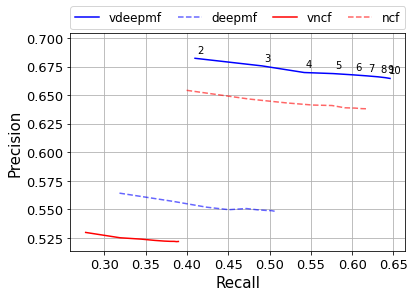

In [ ]:
for m in methods:
    precision = np.zeros(len(num_recommendations))
    recall = np.zeros(len(num_recommendations))
    
    for i, n in enumerate(num_recommendations):
        ids = preds[['user', 'item']].to_numpy()
        y_true = preds['y_test'].to_numpy()
        y_pred = preds[m].to_numpy()
        precision[i], recall[i] = recommender_precision_recall(ids, y_true, y_pred, n, args.like_threshold) 

    c = 'blue' if 'deepmf' in m else 'red'
    alpha = 1 if m[0] == 'v' else 0.6
    ls = '-' if m[0] == 'v' else '--'
        
    plt.plot(recall, precision, c=c, ls=ls, alpha=alpha, label=m)

    if m == 'vdeepmf':
        for i,(r,p) in enumerate(zip(recall, precision)):
            plt.annotate(num_recommendations[i], (r,p), textcoords="offset points", xytext=(5,5), ha='center')
    
plt.xlabel('Recall', fontsize=15); 
plt.ylabel('Precision', fontsize=15)

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.legend(bbox_to_anchor=(0,1.02,1,0.2), fontsize=12, loc="lower left", mode="expand", borderaxespad=0, ncol=len(methods))

plt.grid(True)

ylim_min, ylim_max = plt.ylim()
plt.ylim((ylim_min, ylim_max * 1.02))

plt.show()

In [ ]:
def recommender_ndcg(X, y_true, y_pred, N):
    ndcg = 0
    count = 0
    
    for user_id in np.unique(X[:,0]):
        indices = np.where(X[:,0] == user_id)[0]
        
        user_true = np.array([y_true[i] for i in indices])
        user_pred = np.array([y_pred[i] for i in indices])  
        
        user_true = np.expand_dims(user_true, axis=0)
        user_pred = np.expand_dims(user_pred, axis=0)
                
        if user_true.size > 1:
            ndcg += ndcg_score(user_true, user_pred, k=N, ignore_ties=False)
            count += 1
    
    return ndcg / count

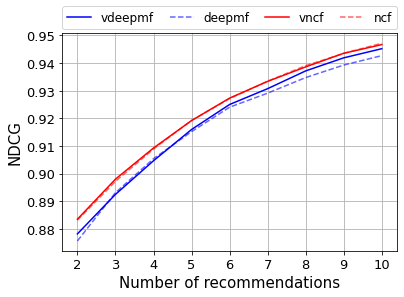

In [ ]:
for m in methods:
    ndcg = np.zeros(len(num_recommendations))
    
    for i, n in enumerate(num_recommendations):
        ids = preds[['user', 'item']].to_numpy()
        y_true = preds['y_test'].to_numpy()
        y_pred = preds[m].to_numpy()
        ndcg[i] = recommender_ndcg(ids, y_true, y_pred, n) 
        
    c = 'blue' if 'deepmf' in m else 'red'
    alpha = 1 if m[0] == 'v' else 0.6
    ls = '-' if m[0] == 'v' else '--'
 
    plt.plot(num_recommendations, ndcg, c=c, ls=ls, alpha=alpha, label=m)

plt.xlabel('Number of recommendations', fontsize=15); 
plt.ylabel('NDCG', fontsize=15)

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.legend(bbox_to_anchor=(0,1.02,1,0.2), fontsize=12, loc="lower left", mode="expand", borderaxespad=0, ncol=len(methods))

plt.grid(True)

plt.show()

---

In [ ]:
!pip install -q watermark
%reload_ext watermark
%watermark -a "Sparsh A." -m -iv -u -t -d

Author: Sparsh A.

Last updated: 2021-11-27 17:24:56

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 5.4.104+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit

IPython   : 5.5.0
numpy     : 1.19.5
keras     : 2.7.0
pandas    : 1.1.5
matplotlib: 3.2.2
tensorflow: 2.7.0



---

**END**